In [20]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Final_df.csv')

In [3]:
df.head()

,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),MM,Species
0,0,39.10,18.7,13.453624,8.229511,8.652405,-25.83352,11,0
1,0,39.50,17.4,13.638182,8.242756,8.949560,-24.69454,11,0
2,0,40.30,18.0,13.964240,8.086410,8.368210,-25.33302,16,0
3,0,44.45,17.3,14.035669,8.306472,8.652405,-25.83352,16,0
4,0,36.70,19.3,13.892444,8.146130,8.766510,-25.32426,16,0


C:\Users\siddh\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\siddh\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


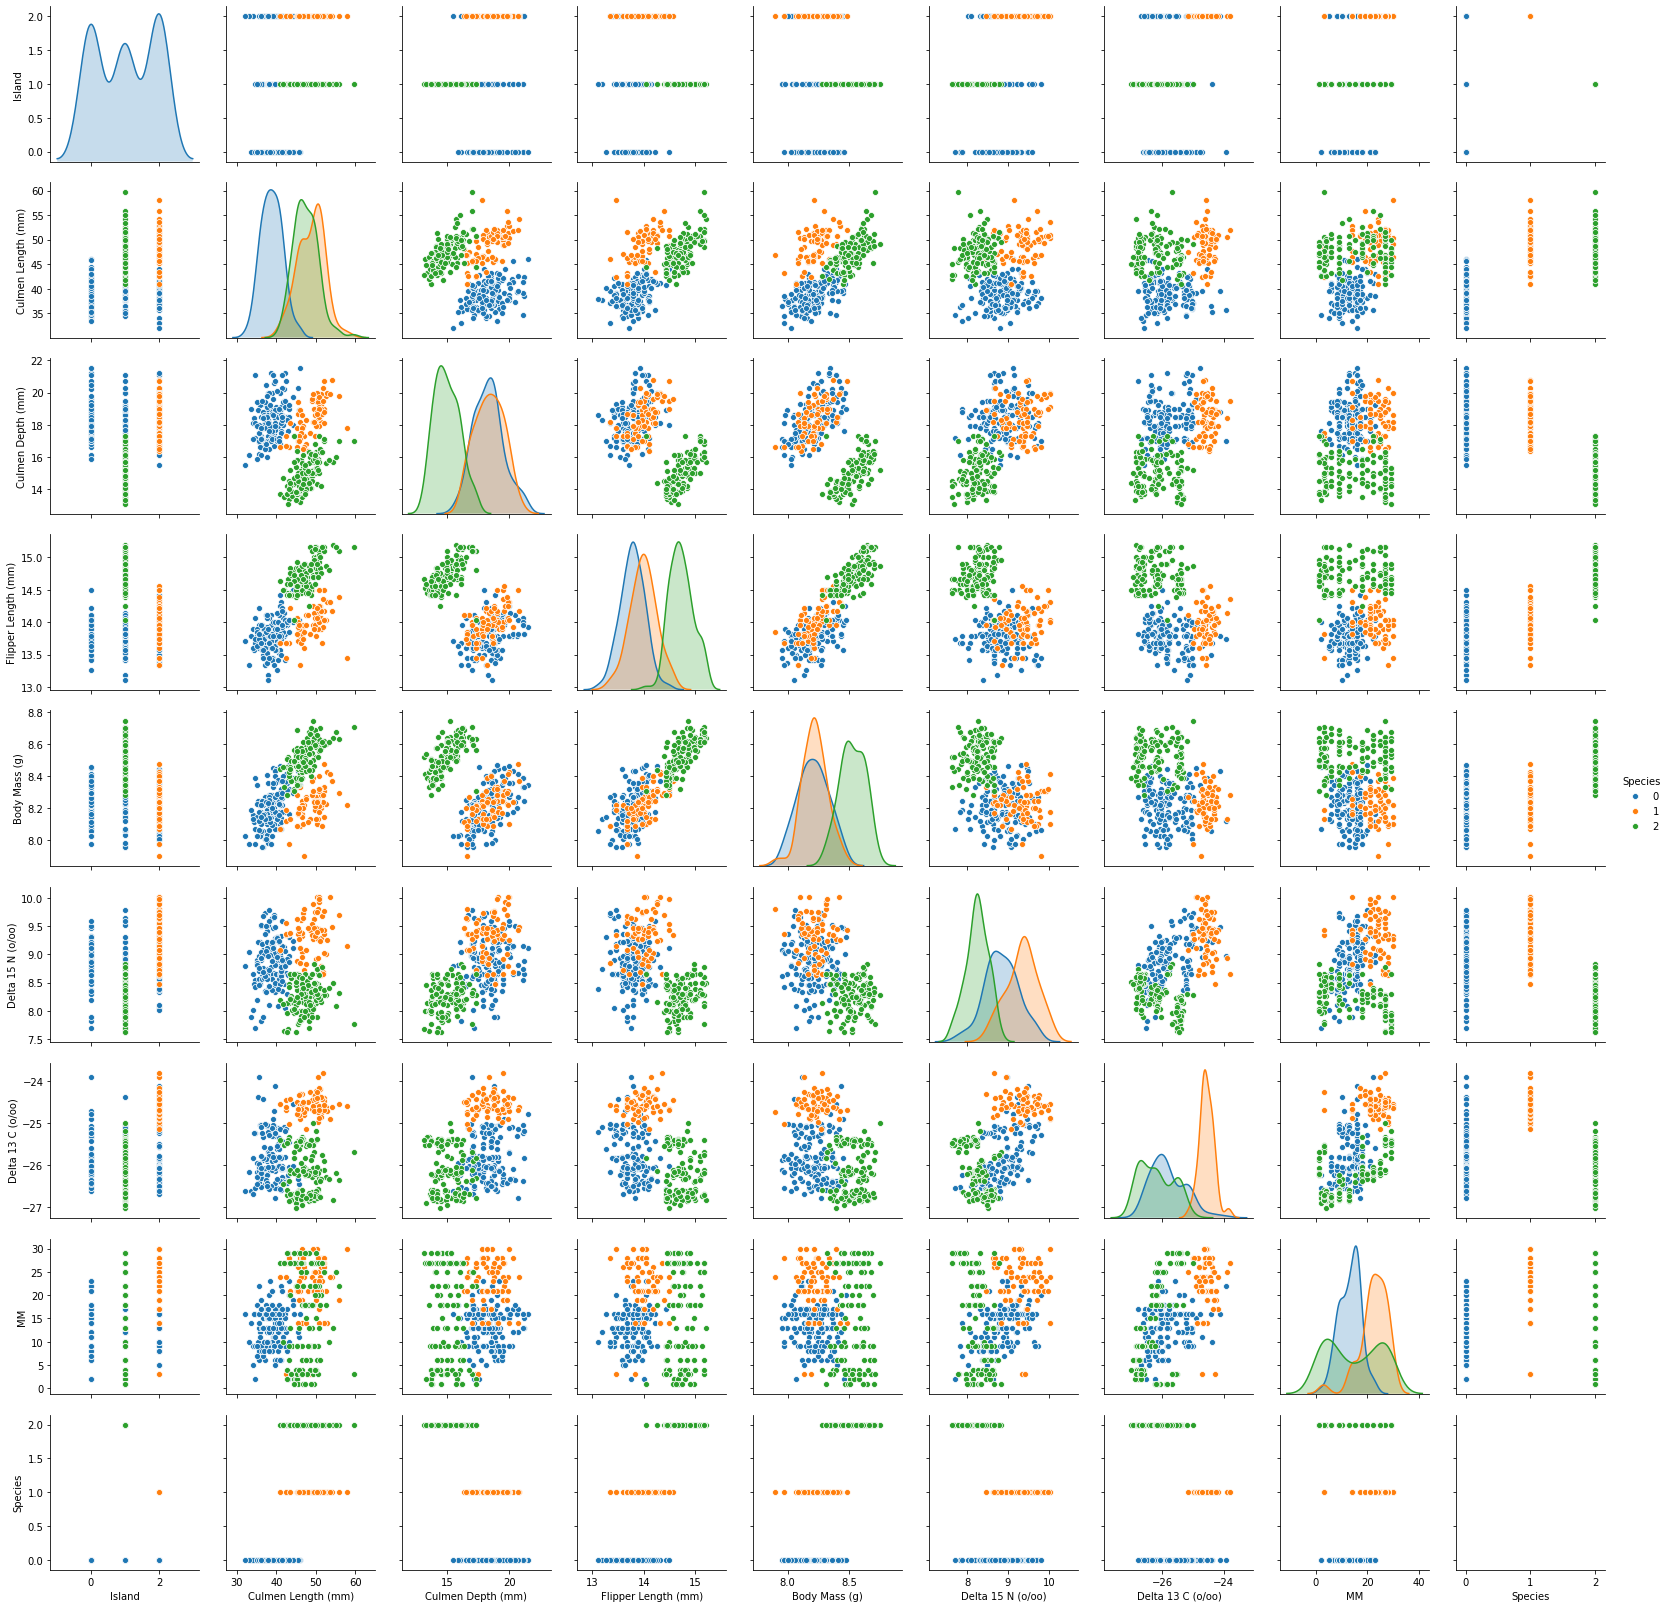

In [5]:
sns.pairplot(df,hue='Species')

#### Since it is a multiclass classification and a lot of dots are inseperable with linear models we go for tree based models and knn

#### KNN requires scaling and one hot encoding for multiclass features, tree algorithms dont need

In [4]:
from sklearn import preprocessing
from sklearn import ensemble
from sklearn import neighbors
from sklearn import model_selection
from sklearn import metrics
import xgboost

In [5]:
def find_accuracy_of_model(model,data,scaling=False,one_hot=False):
    
    df = data.copy()
    if one_hot:
        island = pd.get_dummies(df['Island'])
        df['island0'] = island[0]
        df['island1'] = island[1]
        df['island2'] = island[2]
        df.drop('Island',axis=1,inplace=True)
    
    X = df.drop('Species',axis=1).values
    y = df['Species'].values
    
    accuracies = []

    skf = model_selection.StratifiedKFold(n_splits=10,shuffle=True)
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if scaling:
            ss = preprocessing.StandardScaler()
            X_train = ss.fit_transform(X_train)
            X_test = ss.transform(X_test)

        model.fit(X_train,y_train)
        accuracies.append(model.score(X_test,y_test))

    return np.mean(accuracies)

In [6]:
#KNN
knn = neighbors.KNeighborsClassifier()
print(find_accuracy_of_model(knn,df,scaling=True,one_hot=True))

0.9912605042016807


In [7]:
#RF
rf = ensemble.RandomForestClassifier()
print(find_accuracy_of_model(rf,df))

0.9913445378151261


In [8]:
#XGB
xgb = xgboost.XGBClassifier()
print(find_accuracy_of_model(xgb,df))

0.982436974789916


### Scores of all the 3 are almost the same. RF scored the highest and also it has lot of parameters which can be optimized for better score.

In [10]:
import optuna
from functools import partial

In [11]:
def optimize(trial,X,y):
    accuracies = []
    criterion = trial.suggest_categorical('criterion',['gini','entropy'])
    n_estimators = trial.suggest_int('n_estimators',100,1500)
    max_depth = trial.suggest_int('max_depth',3,10)
    max_features = trial.suggest_uniform('max_features',0.01,1.0)
    
    model = ensemble.RandomForestClassifier(
        n_estimators = n_estimators,
        criterion = criterion,
        max_depth = max_depth,
        max_features = max_features
    )
    
    skf = model_selection.StratifiedKFold(n_splits=10)
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        facc = metrics.accuracy_score(y_test,preds)
        accuracies.append(facc)
        
        return np.mean(accuracies)

In [13]:
X = df.drop('Species',axis=1).values
y = df['Species'].values

optimization_function = partial(optimize,X=X,y=y)
study = optuna.create_study(direction='maximize')

[I 2021-05-09 21:53:38,238] A new study created in memory with name: no-name-3343582d-1da9-4c63-acab-f5f434a550bc


In [14]:
study.optimize(optimization_function,n_trials=15)

[I 2021-05-09 21:53:45,045] Trial 0 finished with value: 1.0 and parameters: {'criterion': 'entropy', 'n_estimators': 772, 'max_depth': 3, 'max_features': 0.05137295671469747}. Best is trial 0 with value: 1.0.
[I 2021-05-09 21:53:46,388] Trial 1 finished with value: 1.0 and parameters: {'criterion': 'gini', 'n_estimators': 566, 'max_depth': 6, 'max_features': 0.8546172534995184}. Best is trial 0 with value: 1.0.
[I 2021-05-09 21:53:46,793] Trial 2 finished with value: 1.0 and parameters: {'criterion': 'gini', 'n_estimators': 197, 'max_depth': 4, 'max_features': 0.7724711617213987}. Best is trial 0 with value: 1.0.
[I 2021-05-09 21:53:48,850] Trial 3 finished with value: 0.9714285714285714 and parameters: {'criterion': 'entropy', 'n_estimators': 813, 'max_depth': 9, 'max_features': 0.7984457747514684}. Best is trial 0 with value: 1.0.
[I 2021-05-09 21:53:49,452] Trial 4 finished with value: 1.0 and parameters: {'criterion': 'gini', 'n_estimators': 317, 'max_depth': 6, 'max_features': 0.

In [15]:
study.best_params

{'criterion': 'entropy',
 'n_estimators': 772,
 'max_depth': 3,
 'max_features': 0.05137295671469747}

In [16]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2,random_state=101)

In [17]:
final_rf = ensemble.RandomForestClassifier(n_estimators=772,criterion='entropy',max_depth=3,max_features=0.05137295671469747)

In [18]:
final_rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=3,
                       max_features=0.05137295671469747, n_estimators=772)

In [19]:
final_rf.score(X_test,y_test)

1.0

In [22]:
pickle.dump(final_rf,open('model.pkl','wb'))